In [215]:
import sklearn
import pandas
import matplotlib.pyplot as plt
import pylab
import seaborn as sns
from tsai.basics import *
from tsai.inference import load_learner
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tsai.inference import load_learner
from sklearn.metrics import mean_squared_error, mean_absolute_error
from datetime import datetime
my_setup(sklearn)

os              : macOS-13.2.1-arm64-arm-64bit
python          : 3.10.10
tsai            : 0.3.6
fastai          : 2.7.12
fastcore        : 1.5.29
sklearn         : 1.2.2
torch           : 2.0.1
cpu cores       : 10
threads per cpu : 1
RAM             : 16.0 GB
GPU memory      : N/A


## Data Import

In [216]:
# dsid = "ILI"
# df_raw = get_long_term_forecasting_data(dsid)
# df_raw

df_initial = pd.read_csv('weatherAUS.csv')
columns = df_initial.columns
df_initial.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [217]:
def plot_missing_values(df):
    """ For each column with missing values plot proportion that is missing."""
    data = [(col, df[col].isnull().sum() / len(df)) 
            for col in df.columns if df[col].isnull().sum() > 0]
    col_names = ['column', 'percent_missing']
    missing_df = pd.DataFrame(data, columns=col_names).sort_values('percent_missing')
    pylab.rcParams['figure.figsize'] = (15, 8)
    missing_df.plot(kind='barh', x='column', y='percent_missing'); 
    plt.title('Percent of missing values in colummns');


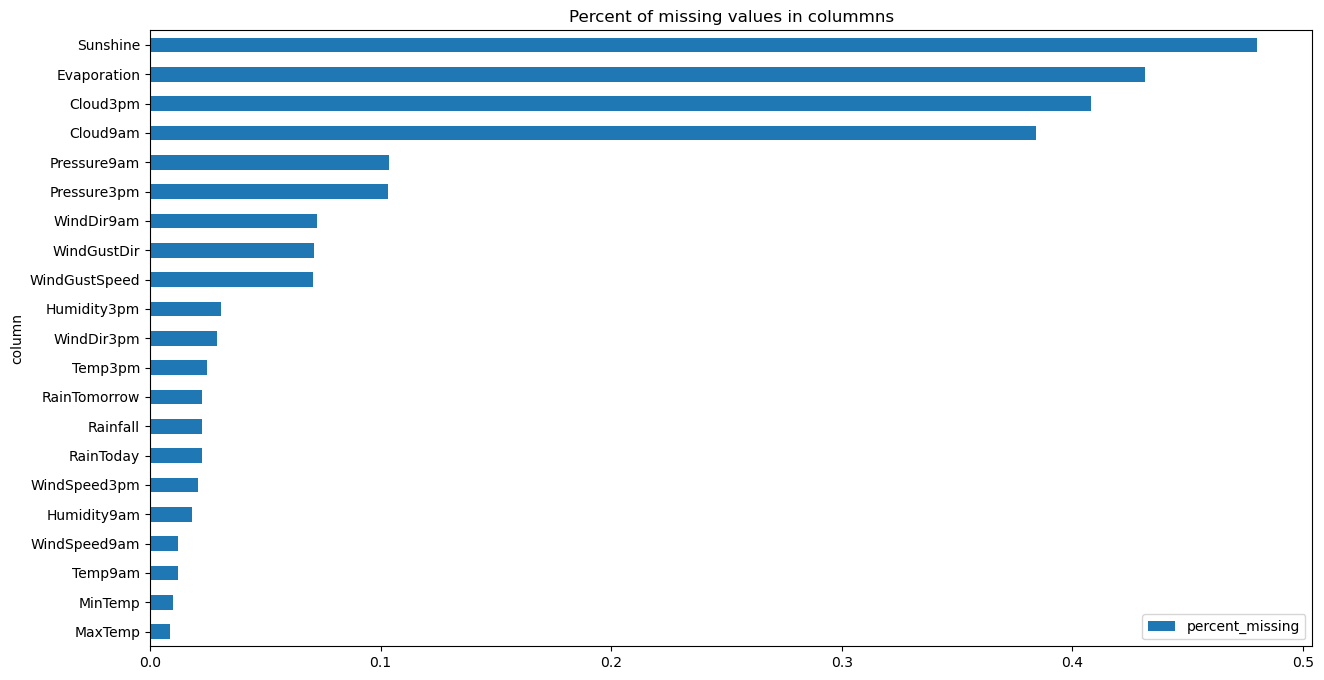

In [218]:
plot_missing_values(df_initial)

In [156]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.impute import SimpleImputer

def check_missing(X):
    print('Number of missing values after imputation: {}'.
          format(pd.DataFrame(X).isnull().sum().sum()))

class ColumnSelector(BaseEstimator, TransformerMixin):
    
    def __init__(self, dtype):
        self.dtype = dtype
    
    def fit(self, X, y=None):
        """ Get either categorical or numerical columns on fit.
        Store as attribute for future reference"""
        X = X if isinstance(X, pd.DataFrame) else pd.DataFrame(X)
        if self.dtype == 'numerical':
            self.cols = X.select_dtypes(exclude='O').columns.tolist()
        elif self.dtype == 'categorical':
            self.cols = X.select_dtypes(include='O').columns.tolist()
        self.col_idx = [X.columns.get_loc(col) for col in self.cols]
        return self

    def transform(self, X):
        """ Subset columns of chosen data type and return np.array"""
        X = X.values if isinstance(X, pd.DataFrame) else X
        return X[:, self.col_idx]
    

num_pipe = Pipeline([
    ('num_selector', ColumnSelector('numerical')),
    ('num_imputer', SimpleImputer(strategy='constant', fill_value=0))
])

cat_pipe = Pipeline([
    ('cat_selector', ColumnSelector('categorical')),
    ('cat_imputer', SimpleImputer(strategy='constant', fill_value='None'))
])

preproc = FeatureUnion([
    ('num_pipe', num_pipe),
    ('cat_pipe', cat_pipe)
])

imputed_res = preproc.fit_transform(df_initial)
check_missing(imputed_res)
type(imputed_res)

In [219]:
columns_to_drop = ['WindDir9am', 'WindGustDir', 'RainToday', 'RainTomorrow', 'WindDir3pm']

In [220]:
df_raw = pd.read_csv('weatherAUS.csv')
df_raw = df_raw.dropna()
df_raw.drop(columns_to_drop, axis = 1, inplace = True)
df_raw = df_raw[df_raw['Location'] == 'Perth']
df_raw.drop(['Location'], axis = 1, inplace = True)
df_raw[['Date']] = df_raw[['Date']].apply(pd.to_datetime)

In [221]:
df_raw.isnull().sum()

Date             0
MinTemp          0
MaxTemp          0
Rainfall         0
Evaporation      0
Sunshine         0
WindGustSpeed    0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Cloud9am         0
Cloud3pm         0
Temp9am          0
Temp3pm          0
dtype: int64

In [222]:
df_raw.tail()

,Date,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
123826,2017-06-21,10.3,19.9,0.2,1.8,7.5,37.0,9.0,15.0,89.0,60.0,1017.1,1013.8,5.0,6.0,13.0,18.5
123827,2017-06-22,13.0,16.8,61.2,3.6,0.0,46.0,17.0,17.0,90.0,75.0,1005.6,1008.9,7.0,7.0,16.4,15.6
123828,2017-06-23,13.3,18.9,0.4,1.8,6.5,37.0,11.0,11.0,85.0,65.0,1019.2,1019.4,6.0,6.0,15.1,18.0
123829,2017-06-24,11.5,18.2,0.0,3.8,9.3,30.0,9.0,11.0,62.0,47.0,1025.9,1023.4,1.0,3.0,14.0,17.6
123830,2017-06-25,6.3,17.0,0.0,1.6,7.9,26.0,4.0,11.0,75.0,49.0,1028.6,1026.0,1.0,3.0,11.5,15.6


## Preprocess Dataframe

In [223]:
datetime_col = "Date"
freq = 'D'
columns = df_raw.columns[1:]
method = 'ffill'
value = 0

# pipeline
preproc_pipe = sklearn.pipeline.Pipeline([
    ('shrinker', TSShrinkDataFrame()), # shrink dataframe memory usage
    ('drop_duplicates', TSDropDuplicates(datetime_col=datetime_col)), # drop duplicate rows (if any)
    ('add_mts', TSAddMissingTimestamps(datetime_col=datetime_col, freq=freq)), # ass missing timestamps (if any)
    ('fill_missing', TSFillMissing(columns=columns, method=method, value=value)), # fill missing data (1st ffill. 2nd value=0)
    ], 
    verbose=True)
mkdir('data', exist_ok=True, parents=True)
save_object(preproc_pipe, 'data/preproc_pipe.pkl')
preproc_pipe = load_object('data/preproc_pipe.pkl')

df = preproc_pipe.fit_transform(df_raw)
df

data directory already exists.
Pipeline saved as data/preproc_pipe.pkl
Initial memory usage: 425.39 KB 
Final memory usage  : 236.33 KB  (-44.4%)
[Pipeline] .......... (step 1 of 4) Processing shrinker, total=   0.0s
[Pipeline] ... (step 2 of 4) Processing drop_duplicates, total=   0.0s
[Pipeline] ........... (step 3 of 4) Processing add_mts, total=   0.0s
[Pipeline] ...... (step 4 of 4) Processing fill_missing, total=   0.0s


,Date,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
0,2008-07-02,6.4,20.700001,0.000000,1.8,7.0,22.0,6.0,9.0,80.0,39.0,1024.099976,1019.000000,0.0,6.0,11.1,19.700001
1,2008-07-03,6.4,20.700001,0.000000,1.8,7.0,22.0,6.0,9.0,80.0,39.0,1024.099976,1019.000000,0.0,6.0,11.1,19.700001
2,2008-07-04,9.5,19.200001,1.800000,1.2,4.7,26.0,11.0,6.0,93.0,73.0,1019.299988,1018.400024,6.0,6.0,13.2,17.700001
3,2008-07-05,9.5,16.400000,1.800000,1.4,4.9,44.0,13.0,17.0,69.0,57.0,1020.400024,1022.099976,7.0,5.0,15.9,16.000000
4,2008-07-06,0.7,15.900000,6.800000,2.4,9.3,24.0,4.0,7.0,86.0,41.0,1032.000000,1029.599976,0.0,1.0,6.9,15.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3276,2017-06-21,10.3,19.900000,0.200000,1.8,7.5,37.0,9.0,15.0,89.0,60.0,1017.099976,1013.799988,5.0,6.0,13.0,18.500000
3277,2017-06-22,13.0,16.799999,61.200001,3.6,0.0,46.0,17.0,17.0,90.0,75.0,1005.599976,1008.900024,7.0,7.0,16.4,15.600000
3278,2017-06-23,13.3,18.900000,0.400000,1.8,6.5,37.0,11.0,11.0,85.0,65.0,1019.200012,1019.400024,6.0,6.0,15.1,18.000000
3279,2017-06-24,11.5,18.200001,0.000000,3.8,9.3,30.0,9.0,11.0,62.0,47.0,1025.900024,1023.400024,1.0,3.0,14.0,17.600000


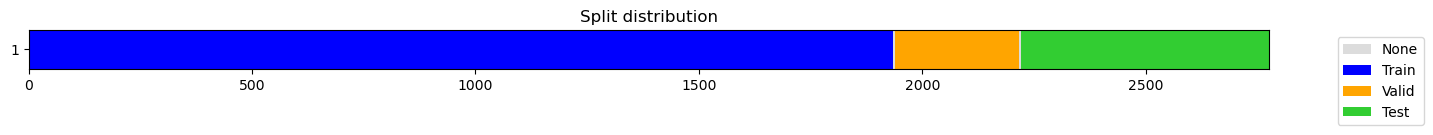

((#1934) [0,1,2,3,4,5,6,7,8,9...],
 (#276) [1940,1941,1942,1943,1944,1945,1946,1947,1948,1949...],
 (#553) [2222,2223,2224,2225,2226,2227,2228,2229,2230,2231...])

In [224]:
fcst_history = 500 # # steps in the past
fcst_horizon = 7  # # steps in the future
valid_size   = 0.1  # int or float indicating the size of the training set
test_size    = 0.2  # int or float indicating the size of the test set

splits = get_forecasting_splits(df, fcst_history=fcst_history, fcst_horizon=fcst_horizon, datetime_col=datetime_col,
                                valid_size=valid_size, test_size=test_size)
splits

## Scale Dataframe

In [225]:
columns = df.columns[1:]
train_split = splits[0]

# pipeline
exp_pipe = sklearn.pipeline.Pipeline([
    ('scaler', TSStandardScaler(columns=columns)), # standardize data using train_split
    ], 
    verbose=True)
save_object(exp_pipe, 'data/exp_pipe.pkl')
exp_pipe = load_object('data/exp_pipe.pkl')

df_scaled = exp_pipe.fit_transform(df, scaler__idxs=train_split)
df_scaled

data directory already exists.
Pipeline saved as data/exp_pipe.pkl
[Pipeline] ............ (step 1 of 1) Processing scaler, total=   0.0s


,Date,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
0,2008-07-02,-1.230196,-0.687656,-0.366148,-1.116652,-0.526045,-1.404622,-1.149512,-1.092087,1.065000,-0.391049,0.949624,0.586666,-1.207894,0.955310,-1.384941,-0.617584
1,2008-07-03,-1.230196,-0.687656,-0.366148,-1.116652,-0.526045,-1.404622,-1.149512,-1.092087,1.065000,-0.391049,0.949624,0.586666,-1.207894,0.955310,-1.384941,-0.617584
2,2008-07-04,-0.633582,-0.932035,-0.020644,-1.296021,-1.208308,-0.993679,-0.087630,-1.656768,1.824330,1.582533,0.241966,0.491235,0.954130,0.955310,-0.983891,-0.951240
3,2008-07-05,-0.633582,-1.388210,-0.020644,-1.236232,-1.148980,0.855565,0.337123,0.413730,0.422491,0.653788,0.404143,1.079745,1.314467,0.573265,-0.468257,-1.234849
4,2008-07-06,-2.327195,-1.469669,0.939091,-0.937283,0.156217,-1.199151,-1.574265,-1.468541,1.415460,-0.274956,2.114317,2.272688,-1.207894,-0.954915,-2.187040,-1.318263
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3276,2017-06-21,-0.479617,-0.817992,-0.327759,-1.116652,-0.377727,0.136415,-0.512383,0.037276,1.590690,0.827928,-0.082380,-0.240443,0.593793,0.955310,-1.022087,-0.817778
3277,2017-06-22,0.040014,-1.323042,11.381001,-0.578545,-2.602496,1.061037,1.186628,0.413730,1.649100,1.698626,-1.777815,-1.019826,1.314467,1.337355,-0.372769,-1.301580
3278,2017-06-23,0.097751,-0.980911,-0.289369,-1.116652,-0.674363,0.136415,-0.087630,-0.715633,1.357050,1.118160,0.227227,0.650294,0.954130,0.955310,-0.621037,-0.901192
3279,2017-06-24,-0.248670,-1.094955,-0.366148,-0.518755,0.156217,-0.582736,-0.512383,-0.715633,0.013621,0.073323,1.215003,1.286530,-0.847556,-0.190825,-0.831111,-0.967923


## Sliding Window

In [226]:
x_vars = df.columns[1:]
y_vars = df.columns[1:]
X, y = prepare_forecasting_data(df, fcst_history=fcst_history, fcst_horizon=fcst_horizon, x_vars=x_vars, y_vars=y_vars)
X.shape, y.shape

((2775, 16, 500), (2775, 16, 7))

In [227]:
# Just for MacUsers

X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

In [228]:
arch_config = dict(
    n_layers=3,  # number of encoder layers
    n_heads=4,  # number of heads
    d_model=16,  # dimension of model
    d_ff=128,  # dimension of fully connected network
    attn_dropout=0.0, # dropout applied to the attention weights
    dropout=0.3,  # dropout applied to all linear layers in the encoder except q,k&v projections
    patch_len=24,  # length of the patch applied to the time series to create patches
    stride=2,  # stride used when creating patches
    padding_patch=True,  # padding_patch
)

In [229]:
learn = TSForecaster(X, y, splits=splits, batch_size=16, path="models", pipelines=[preproc_pipe, exp_pipe],
                     arch="PatchTST", arch_config=arch_config, metrics=[mse, mae], cbs=ShowGraph())

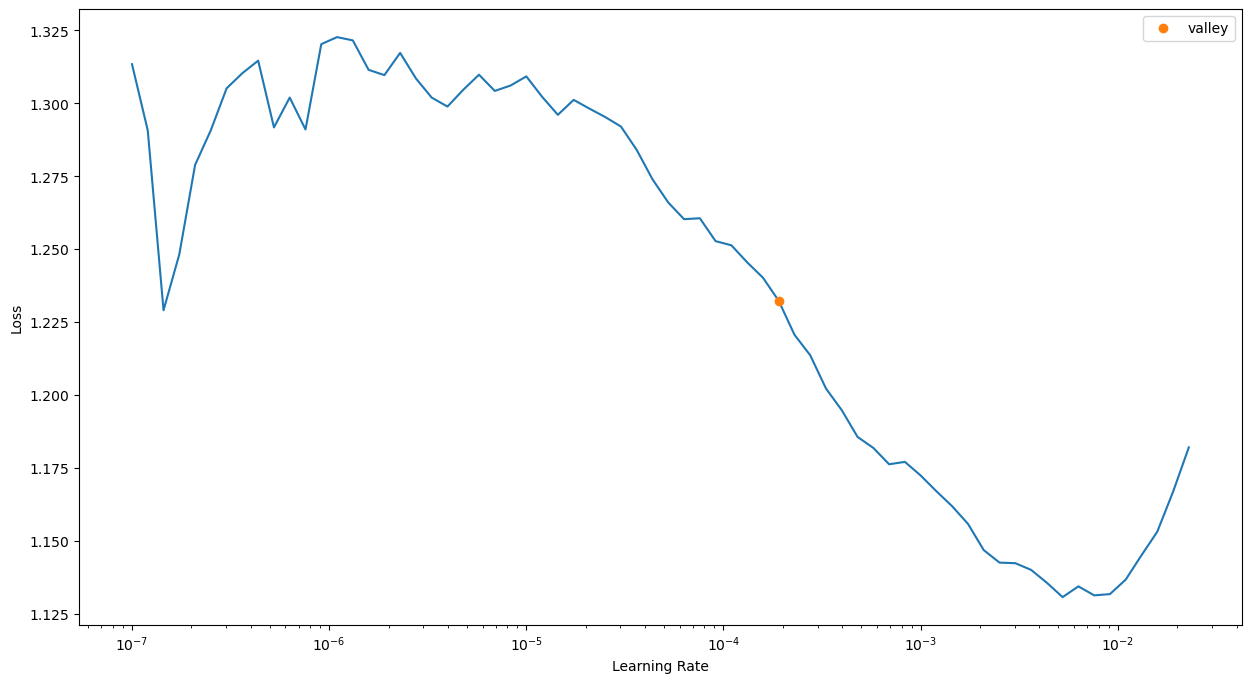

In [230]:
lr_max = learn.lr_find().valley

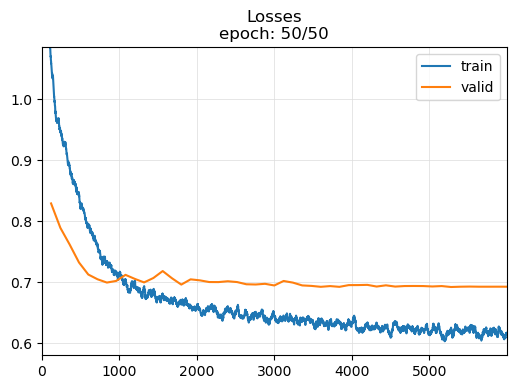

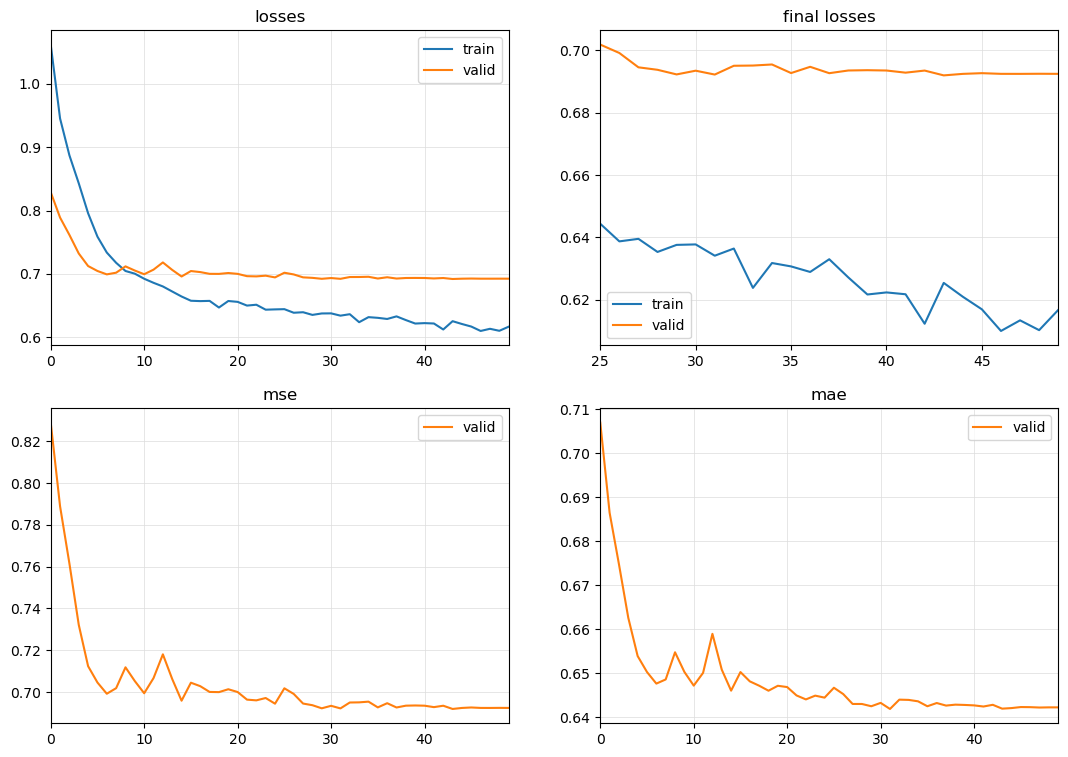

In [231]:
learn = TSForecaster(X, y, splits=splits, batch_size=16, path="models", pipelines=[preproc_pipe, exp_pipe],
                     arch="PatchTST", arch_config=arch_config, metrics=[mse, mae], cbs=[ShowGraph()])

n_epochs = 50
lr_max = lr_max
learn.fit_one_cycle(n_epochs, lr_max=lr_max)
learn.export('patchTST.pt')

## Evaluate model

In [232]:
learn = load_learner('models/patchTST.pt')
scaled_preds, *_ = learn.get_X_preds(X[splits[1]])
scaled_preds = to_np(scaled_preds)
print(f"scaled_preds.shape: {scaled_preds.shape}")

scaled_y_true = y[splits[1]]
results_df = pd.DataFrame(columns=["mse", "mae"])
results_df.loc["valid", "mse"] = mean_squared_error(scaled_y_true.flatten(), scaled_preds.flatten())
results_df.loc["valid", "mae"] = mean_absolute_error(scaled_y_true.flatten(), scaled_preds.flatten())
results_df

scaled_preds.shape: (276, 16, 7)


,mse,mae
valid,0.692651,0.642421


## Test Inference

In [233]:
learn = load_learner('models/patchTST.pt')
y_test_preds, *_ = learn.get_X_preds(X[splits[2]])
y_test_preds = to_np(y_test_preds)
print(f"y_test_preds.shape: {y_test_preds.shape}")

y_test = y[splits[2]]
results_df = pd.DataFrame(columns=["mse", "mae"])
results_df.loc["test", "mse"] = mean_squared_error(y_test.flatten(), y_test_preds.flatten())
results_df.loc["test", "mae"] = mean_absolute_error(y_test.flatten(), y_test_preds.flatten())
results_df

y_test_preds.shape: (553, 16, 7)


,mse,mae
test,0.742294,0.633471


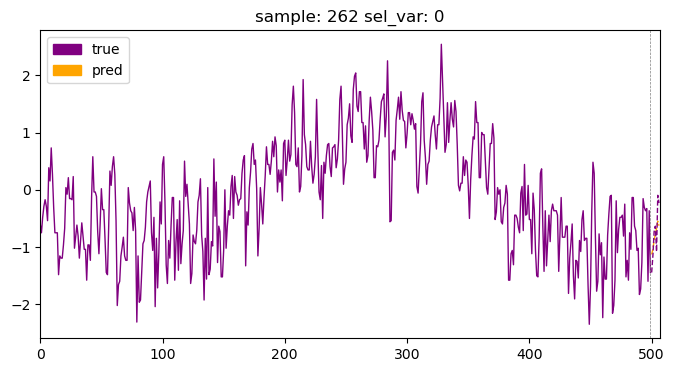

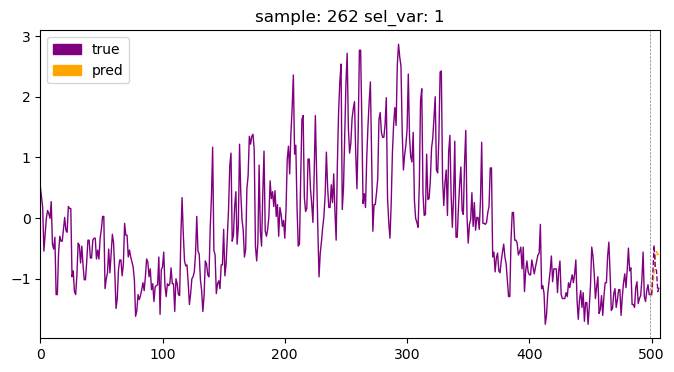

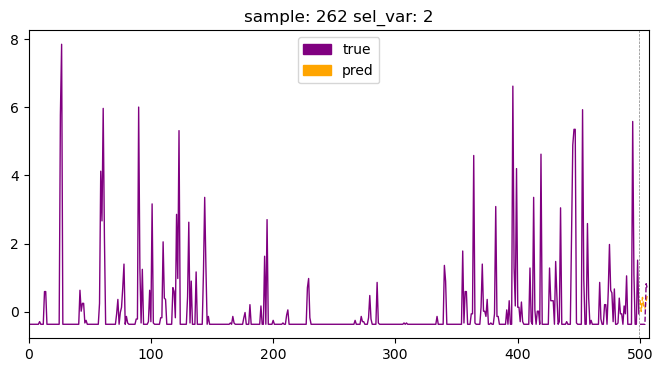

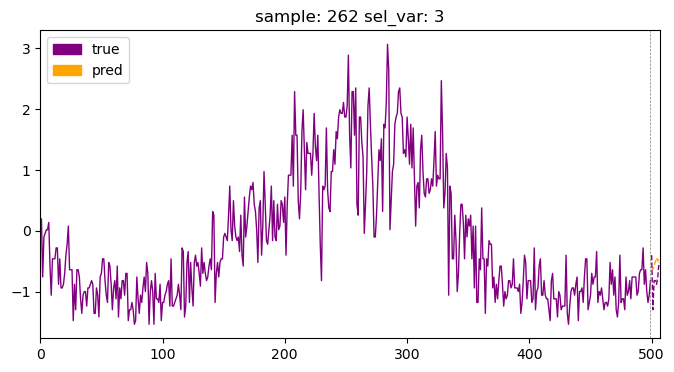

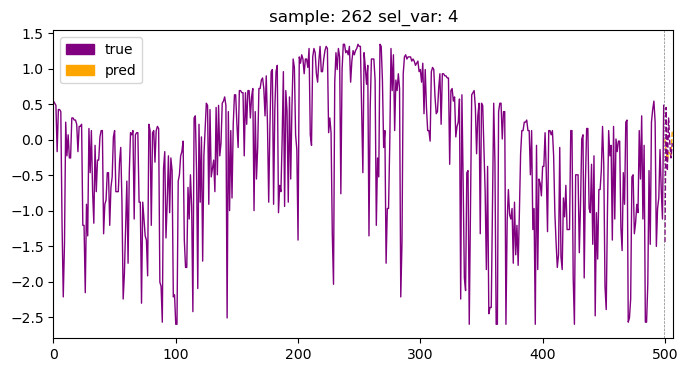

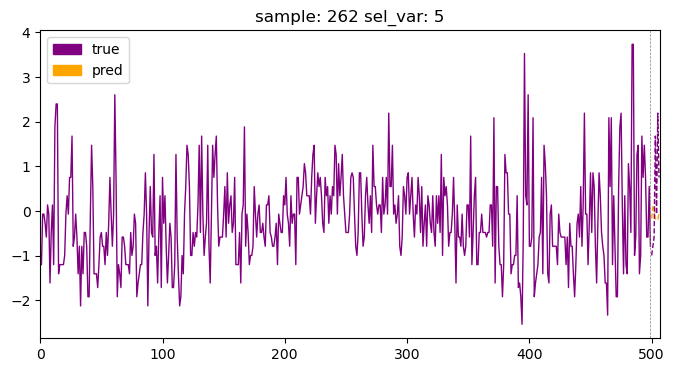

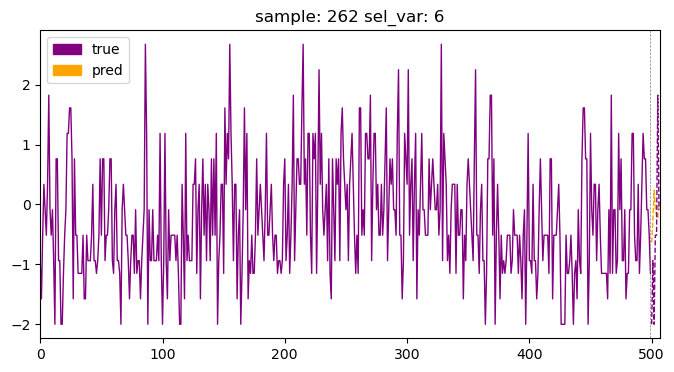

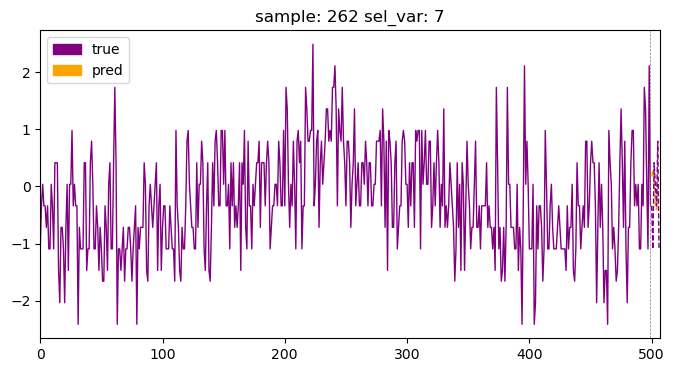

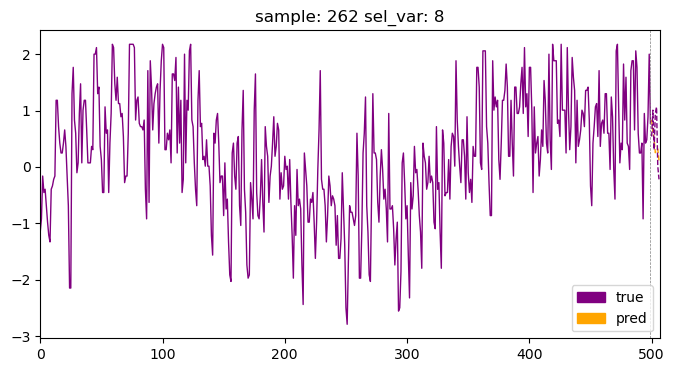

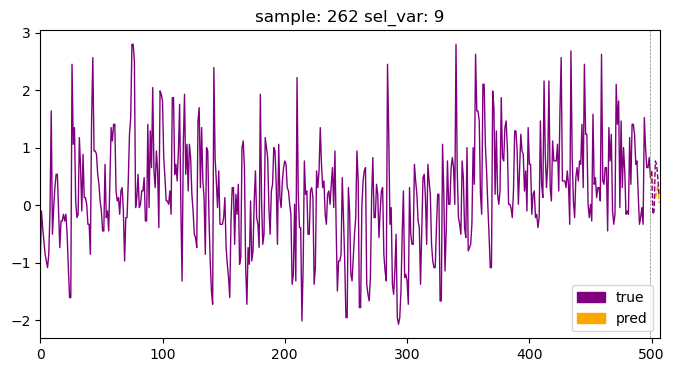

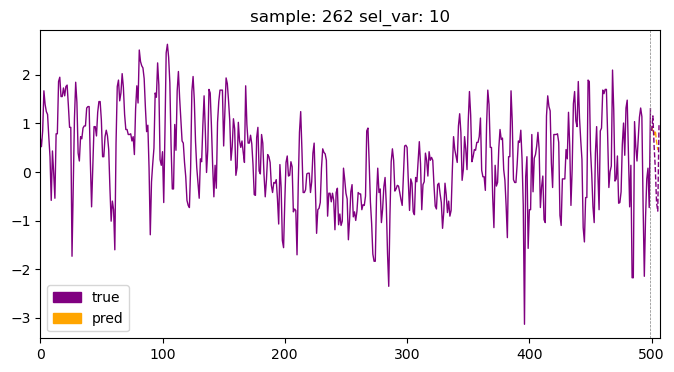

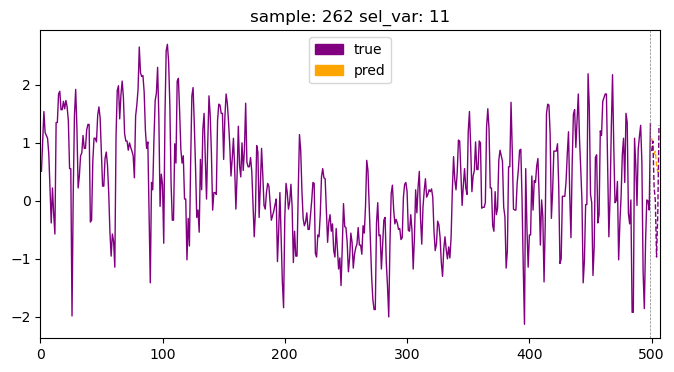

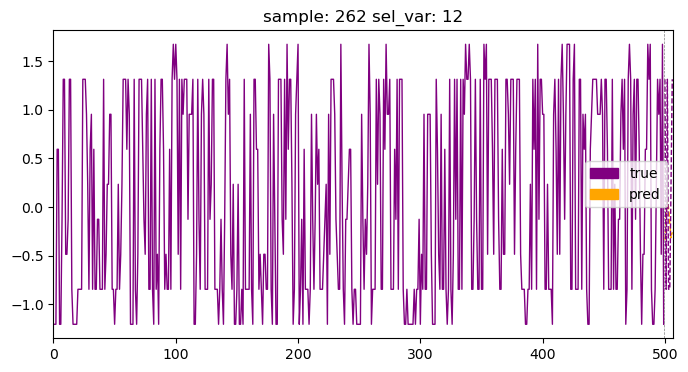

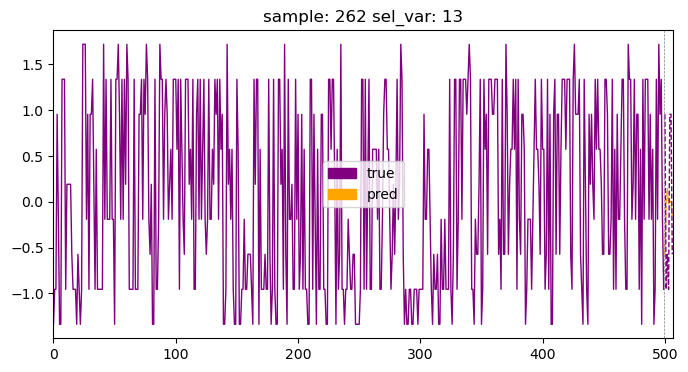

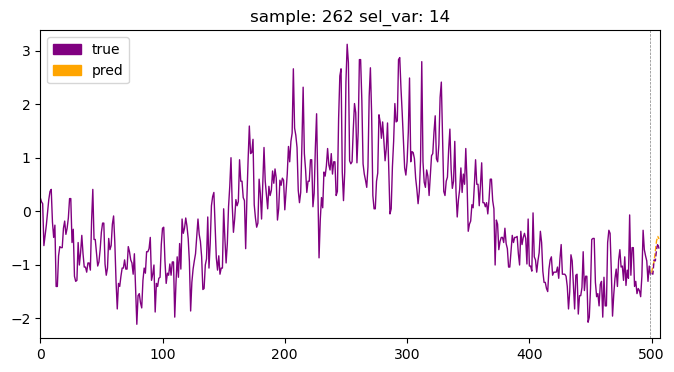

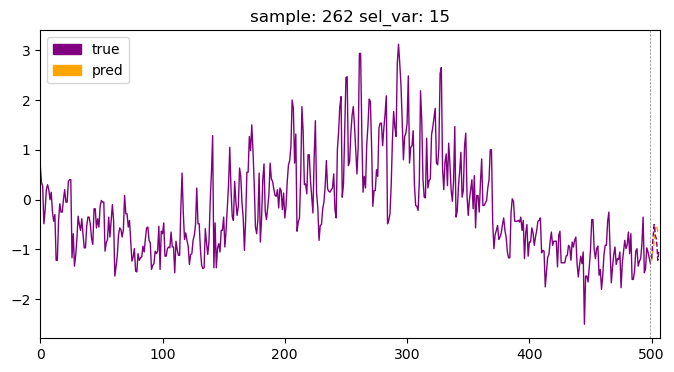

In [234]:
X_test = X[splits[2]]
y_test = y[splits[2]]
plot_forecast(X_test, y_test, y_test_preds, sel_vars=True)

In [235]:
fcst_date = "2017-06-21"
dates = pd.date_range(start=None, end=fcst_date, periods=fcst_history, freq=freq)
dates

DatetimeIndex(['2016-02-08', '2016-02-09', '2016-02-10', '2016-02-11',
               '2016-02-12', '2016-02-13', '2016-02-14', '2016-02-15',
               '2016-02-16', '2016-02-17',
               ...
               '2017-06-12', '2017-06-13', '2017-06-14', '2017-06-15',
               '2017-06-16', '2017-06-17', '2017-06-18', '2017-06-19',
               '2017-06-20', '2017-06-21'],
              dtype='datetime64[ns]', length=500, freq='D')

In [236]:

new_df = pd.read_csv('weatherAUS.csv')
new_df = new_df.dropna()
new_df.drop(columns_to_drop, axis = 1, inplace = True)
new_df = new_df[new_df['Location'] == 'Perth']
new_df.drop(['Location'], axis = 1, inplace = True)
new_df[['Date']] = new_df[['Date']].apply(pd.to_datetime)

new_df = new_df[new_df['Date'].isin(dates)].reset_index(drop=True)
save_new_df = new_df


learn = load_learner('models/patchTST.pt')
new_df = learn.transform(new_df)

Initial memory usage: 63.88 KB  
Final memory usage  : 33.88 KB   (-47.0%)


In [237]:
x_feat = new_df.columns[1:]
new_X, _ = prepare_forecasting_data(new_df, fcst_history=fcst_history, fcst_horizon=0, x_vars=x_vars, y_vars=None)

In [238]:
new_scaled_preds, *_ = learn.get_X_preds(new_X)

new_scaled_preds = to_np(new_scaled_preds).swapaxes(1,2).reshape(-1, len(y_vars))
dates = pd.date_range(start=fcst_date, periods=fcst_horizon + 1, freq='7D')[1:]
preds_df = pd.DataFrame(dates, columns=[datetime_col])
preds_df.loc[:, y_vars] = new_scaled_preds
preds_df = learn.inverse_transform(preds_df)

In [239]:
df_total_pred= pd.concat([save_new_df, preds_df], ignore_index = True)
df_total_pred = df_total_pred.iloc[-200:]

In [240]:
columns_full=list(new_df.columns)
dict_name = {x: y for x, y in enumerate(columns_full)}
df_total_pred.rename(columns=dict_name, inplace=True)

2017-06-21 00:00:00


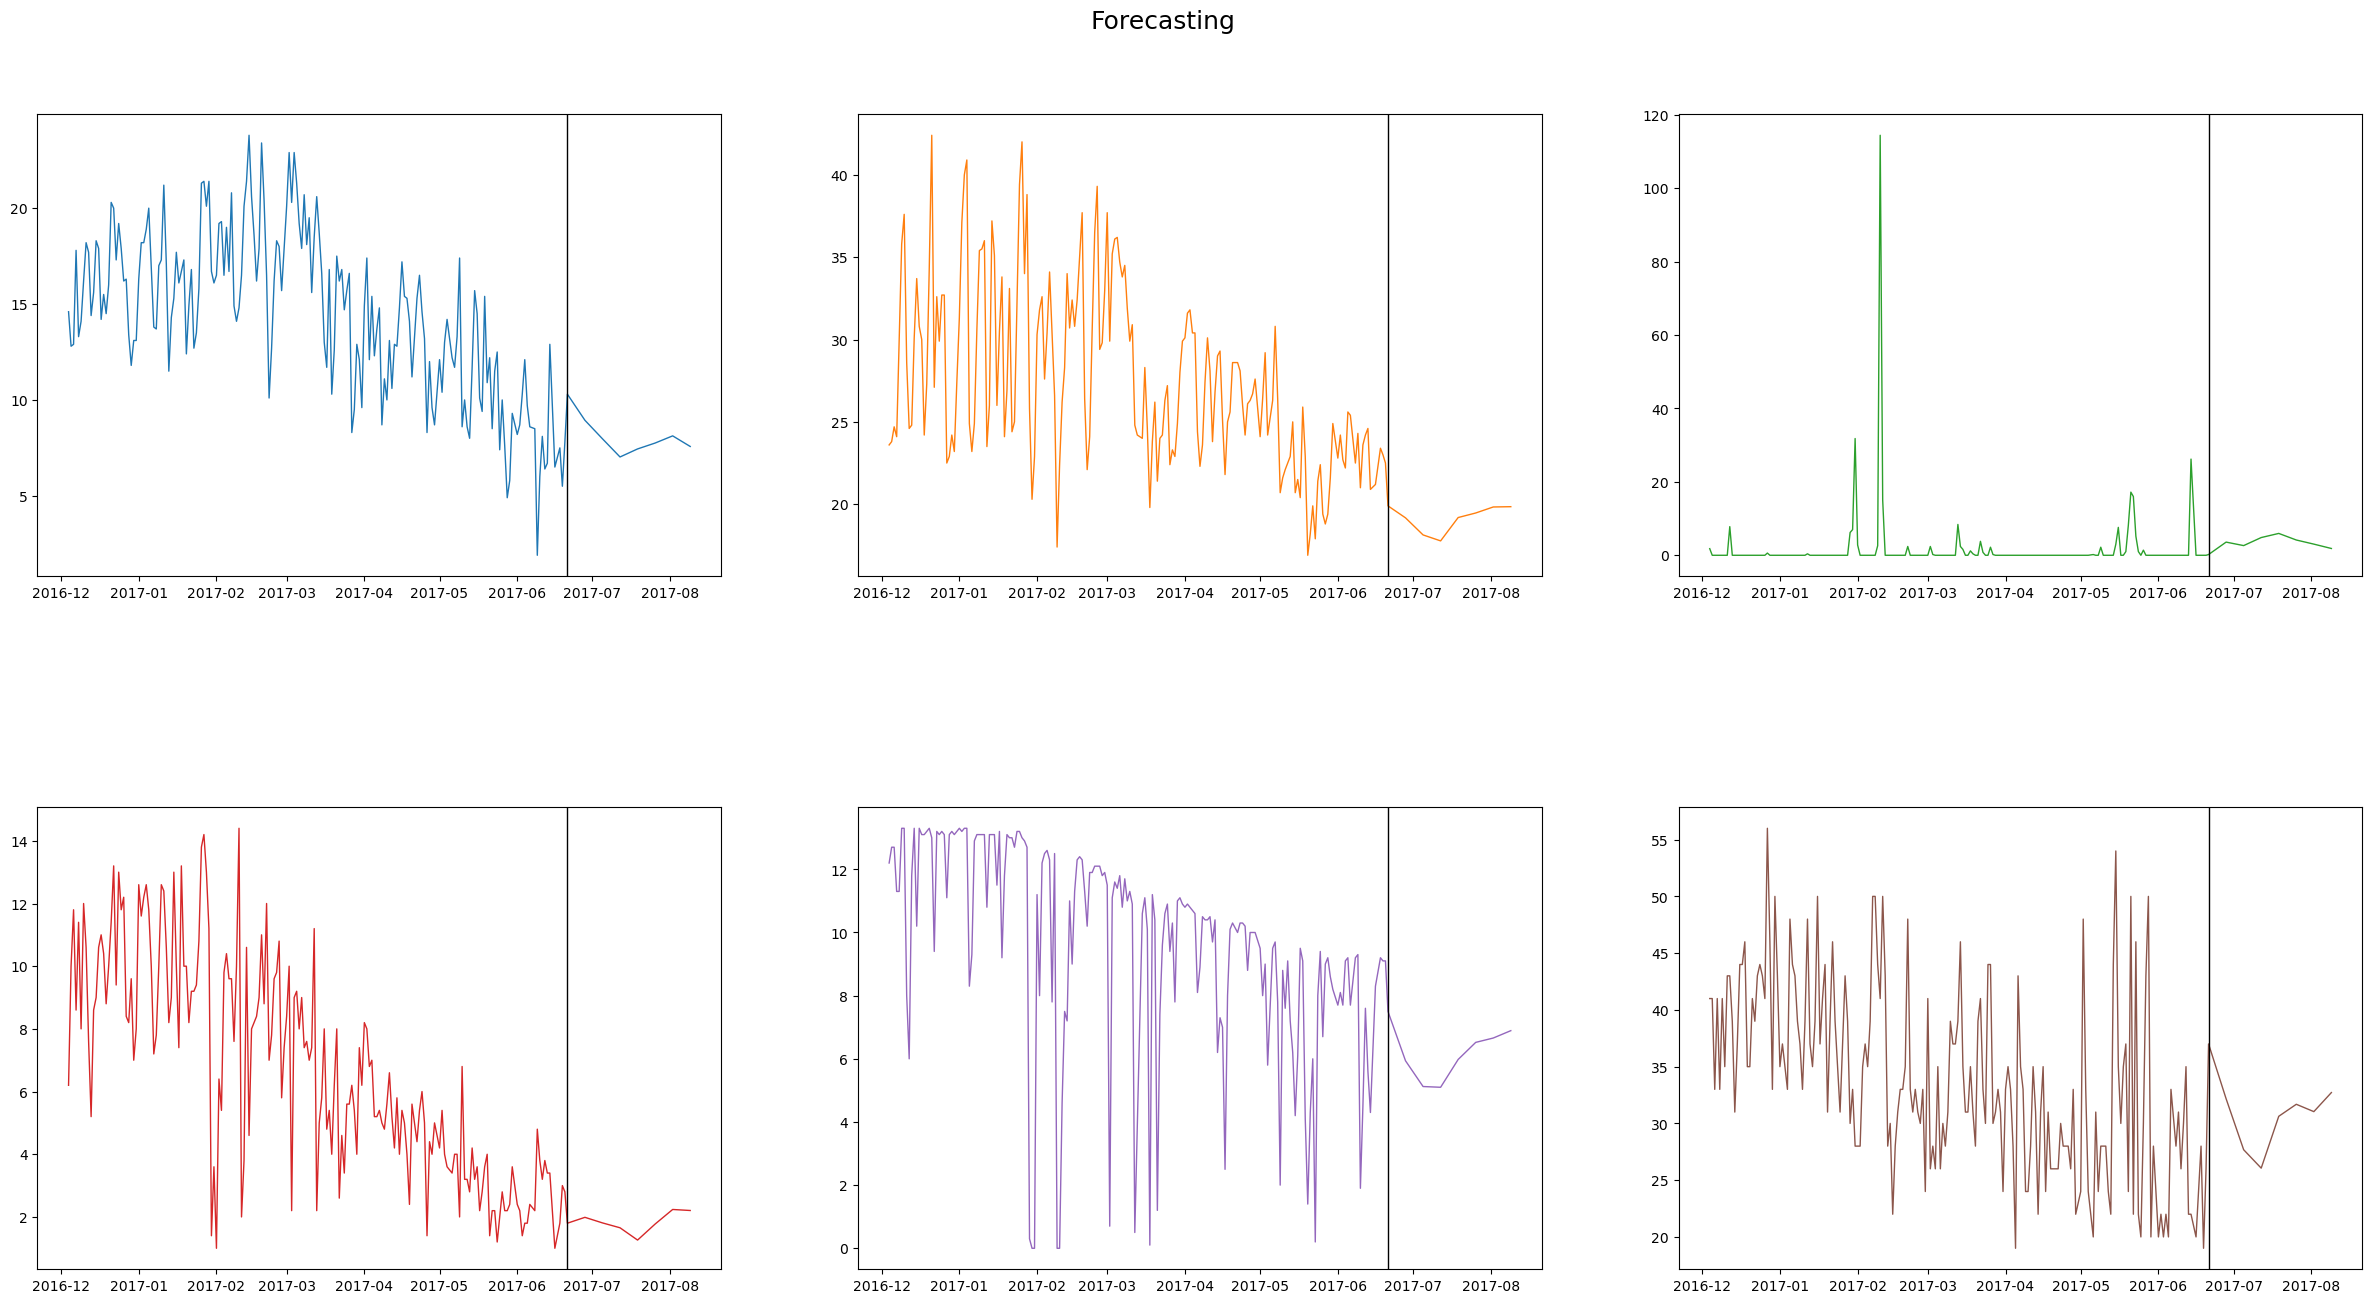

In [241]:

date_str = fcst_date
date_format = '%Y-%m-%d'
date_obj = datetime.strptime(date_str, date_format)
print(date_obj)

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(30, 15))
plt.subplots_adjust(hspace=0.5)
fig.suptitle("Forecasting", fontsize=18, y=0.95)
colors = ['C{}'.format(k) for k in range(16)]

for i, (column, ax) in enumerate(zip(columns_full[1:], axs.ravel())):
    # filter df for ticker and plot on specified axes
    ax.plot(df_total_pred['Date'], df_total_pred[column], linestyle='-', color = colors[i],linewidth=1)
    ax.axvline(x=date_obj, linewidth=1, color='black')

plt.show()